# Example development notebook for `app_predict`

Related wiki page:  
https://github.com/stharrold/demo/wiki/app_predict

In [1]:
cd /opt/demo

/opt/demo


In [2]:
# Import standard packages.
import os
import sys
import time
# Import installed packages.
# Import local packages.
sys.path.insert(0, os.path.join(os.path.curdir, r'demo'))
%reload_ext autoreload
%autoreload 2
import demo
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("demo:", demo.__version__)

Timestamp:
2017-02-27T03:17:41GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
demo: 0.0.0


In [4]:
!py.test -v --pdb

============================= test session starts ==============================
platform linux -- Python 3.5.2, pytest-2.9.2, py-1.4.31, pluggy-0.3.1 -- /opt/conda/bin/python
cachedir: .cache
rootdir: /opt/demo, inifile: 
collected 8 items 

tests/test__init__.py::test__all__ PASSED
tests/test__init__.py::test__version__ PASSED
tests/test_app_template/test_app_template__init__.py::test__all__ PASSED
tests/test_app_template/test_app_template_main.py::test__all__ PASSED
tests/test_app_template/test_app_template_main.py::test_main PASSED
tests/test_app_template/test_app_template_main.py::test__main__ PASSED
tests/test_app_template/test_template.py::test_prepend_this PASSED
tests/test_utils/test_utils__init__.py::test__all__ PASSED

=========================== 8 passed in 5.51 seconds ===========================


# Development below

## Initialization

### Imports

In [1]:
cd /opt/demo

/opt/demo


In [2]:
# Import standard packages.
import bs4
import collections
import gc
import glob
import io
import os
import pickle
import requests
import shelve
import subprocess
import sys
import textwrap
import time
import warnings
# Import installed packages.
import geopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn as sk
import sklearn.cross_validation as sk_cv
import sklearn.cluster as sk_cl
import sklearn.decomposition as sk_dc
import sklearn.ensemble as sk_ens
import sklearn.metrics as sk_met
import sklearn.preprocessing as sk_pre
# Import local packages.
# datascience version: TODO link to GitHub tag v0.0.1.
sys.path.insert(0, os.path.join(os.path.curdir, r'demo'))
%reload_ext autoreload
%autoreload 2
import demo
%matplotlib inline

In [3]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("matplotlib:", mpl.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sk.__version__)
print("seaborn:", sns.__version__)
print("demo:", demo.__version__)

Timestamp:
2017-02-27T19:46:43GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
matplotlib: 1.5.1
numpy: 1.11.1
pandas: 0.18.1
scipy: 0.17.1
sklearn: 0.17.1
seaborn: 0.7.1
demo: 0.0.0


In [4]:
# State settings.
sns.set() # Set matplot lib styles with seaborn
np.random.seed(seed=1) # Set random state for reproducibility.

# File paths
path_data_dir = os.path.join(os.path.abspath(os.path.curdir), r'demo/app_predict/data')
path_csv = os.path.join(path_data_dir, r'Risky Dealer Case Study Transactions.csv')

# Statistics
# percentiles = [-1.6449 sigma, -1 sigma, mean, +1 sigma, +1.6449 sigma] for normal distribution
# 90.00% confidence interval = (percentiles[0], percentiles[-1])
# 68.27% confidence interval = (percentiles[1], percentiles[-2])
# median = percentiles[2]
percentiles = [0.0500, 0.1587, 0.5000, 0.8413, 0.9500]

## Extract, transform, and load

In [5]:
print(r"""`df`: Load and format sales transactions.""")
df_orig = pd.read_csv(path_csv)
df_orig.head()

`df`: Load and format sales transactions.


,BuyerID,SellerID,Mileage,VIN,SellingLocation,CarMake,SalePrice,CarYear,MMR,JDPowersCat,...,Salvage,OVE,Simulcast,InLane,PSIEligible,SaleDate,Autocheck_score,ConditionReport,DSEligible,Returned
0,351757,441081,37055,1FAHP3M27CL374352,CAAI,FORD,13000,2012,13050,COMPACT CAR,...,0,0,0,0,1,13-07-25,1.000000,NaN,1,0.0
1,351757,442235,248,1G1JE6SB7D4103706,DETA,CHEVROLET,13900,2013,13600,COMPACT CAR,...,0,0,0,0,1,13-10-24,NaN,NaN,1,NaN
2,351757,436280,39627,1G1PG5SC4C7102274,CAAI,CHEVROLET,13800,2012,14050,MIDSIZE CAR,...,0,0,0,1,1,13-04-18,-2.666667,41,1,NaN
3,351757,436280,50773,1G1PG5SC5C7113820,CAAI,CHEVROLET,12900,2012,13150,MIDSIZE CAR,...,0,0,0,1,1,13-04-18,1.000000,31,1,NaN
4,351757,434202,54133,1GNKVGED4BJ301146,SVAA,CHEVROLET,17800,2011,18050,SUV,...,0,0,0,1,1,13-02-26,-1.400000,34,1,NaN


In [6]:
df = demo.app_predict.predict.etl(df=df_orig)
df = demo.app_predict.predict.create_features(df=df, path_data_dir=path_data_dir)
with pd.option_context('display.max_rows', len(df.dtypes)):
    print(df.dtypes)

BuyerID                                                      object
SellerID                                                     object
Mileage                                                       int64
VIN                                                          object
SellingLocation                                              object
CarMake                                                      object
SalePrice                                                     int64
CarYear                                                       int64
MMR                                                           int64
JDPowersCat                                                  object
LIGHTG                                                        int64
LIGHTY                                                        int64
LIGHTR                                                        int64
PSI                                                           int64
Arbitrated                                      

## Exploratory data analysis

In [17]:
# Define target and features
# TODO: Shuffle records, features
# features = np.random.permutation(list(features))
# df = df.sample(frac=1, replace=False)
target = 'Returned_asm'
features = set(df.columns[np.logical_or(df.dtypes=='int64', df.dtypes=='float64')])
features.difference_update(['DSEligible', 'Returned', target])
features = sorted(features)

In [19]:
# Describe features
opt = pd.get_option('display.max_columns')
pd.set_option('display.max_columns', len(features))
df[features].describe(include='all')

,Arbitrated,Autocheck_score,BuyerID_fracDSEligible1DivTransactions,BuyerID_fracReturned1DivReturnedNotNull,BuyerID_fracReturnedNotNullDivDSEligible1,BuyerID_fracReturnedasm1DivTransactions,BuyerID_numDSEligible1,BuyerID_numReturned1,BuyerID_numReturnedNotNull,BuyerID_numReturnedasm1,BuyerID_numTransactions,CarMake_fracDSEligible1DivTransactions,CarMake_fracReturned1DivReturnedNotNull,CarMake_fracReturnedNotNullDivDSEligible1,CarMake_fracReturnedasm1DivTransactions,CarMake_numDSEligible1,CarMake_numReturned1,CarMake_numReturnedNotNull,CarMake_numReturnedasm1,CarMake_numTransactions,CarYear,ConditionReport,InLane,JDPowersCat_COMPACTCAR,JDPowersCat_EXCLUDED,JDPowersCat_FULLSIZECAR,JDPowersCat_LUXURYCAR,JDPowersCat_MIDSIZECAR,JDPowersCat_PICKUP,JDPowersCat_SPORTSCAR,JDPowersCat_SUV,JDPowersCat_UNKNOWN,JDPowersCat_VAN,JDPowersCat_fracDSEligible1DivTransactions,JDPowersCat_fracReturned1DivReturnedNotNull,JDPowersCat_fracReturnedNotNullDivDSEligible1,JDPowersCat_fracReturnedasm1DivTransactions,JDPowersCat_numDSEligible1,JDPowersCat_numReturned1,JDPowersCat_numReturnedNotNull,JDPowersCat_numReturnedasm1,JDPowersCat_numTransactions,LIGHTG,LIGHTR,LIGHTY,LIGHT_N0G1Y2R3,MMR,Mileage,OVE,PSI,PSIEligible,SaleDate_day,SaleDate_decyear,SaleDate_dow,SaleDate_doy,SalePrice,Salvage,SellerID_fracDSEligible1DivTransactions,SellerID_fracReturned1DivReturnedNotNull,SellerID_fracReturnedNotNullDivDSEligible1,SellerID_fracReturnedasm1DivTransactions,SellerID_numDSEligible1,SellerID_numReturned1,SellerID_numReturnedNotNull,SellerID_numReturnedasm1,SellerID_numTransactions,SellingLocation_fracDSEligible1DivTransactions,SellingLocation_fracReturned1DivReturnedNotNull,SellingLocation_fracReturnedNotNullDivDSEligible1,SellingLocation_fracReturnedasm1DivTransactions,SellingLocation_lat,SellingLocation_lon,SellingLocation_numDSEligible1,SellingLocation_numReturned1,SellingLocation_numReturnedNotNull,SellingLocation_numReturnedasm1,SellingLocation_numTransactions,Simulcast,VIN_fracDSEligible1DivTransactions,VIN_fracReturned1DivReturnedNotNull,VIN_fracReturnedNotNullDivDSEligible1,VIN_fracReturnedasm1DivTransactions,VIN_numDSEligible1,VIN_numReturned1,VIN_numReturnedNotNull,VIN_numReturnedasm1,VIN_numTransactions
count,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.00000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000
mean,0.071316,1.198252,0.944876,0.224325,0.074882,0.070095,906.093480,4.054668,34.450741,25.056956,927.095769,0.944876,0.211503,0.075175,0.070095,19687.983211,276.293497,1440.582668,1484.852567,20896.542281,2007.407140,30.818285,0.333700,0.125208,0.004800,0.011723,0.116345,0.221070,0.129473,0.032493,0.304778,0.001279,0.052832,0.944876,0.211736,0.074806,0.070095,50731.510123,798.60481,3810.885825,3437.368510,53370.273823,0.267977,0.217998,0.042592,1.007157,11388.524882,84228.544933,0.034034,0.306650,0.690659,15.596895,2013.526312,1.939318,193.630351,1197

In [20]:
pd.set_option('display.max_columns', opt)

################################################################################
Feature: Arbitrated


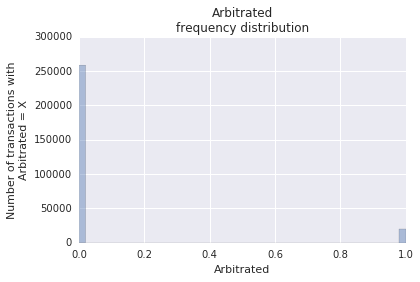

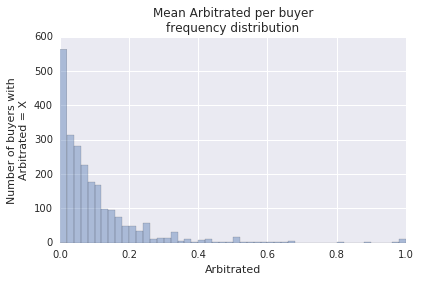

################################################################################
Feature: Autocheck_score


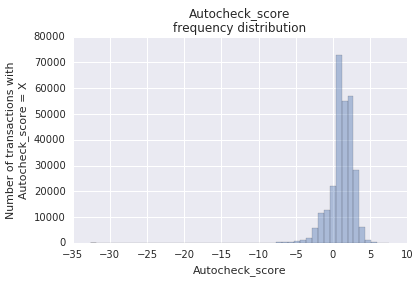

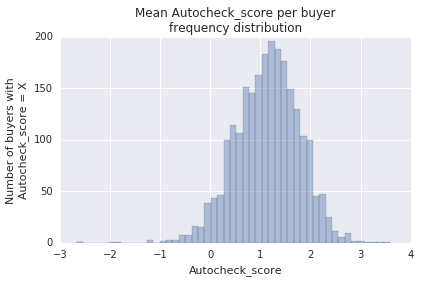

################################################################################
Feature: BuyerID_fracDSEligible1DivTransactions


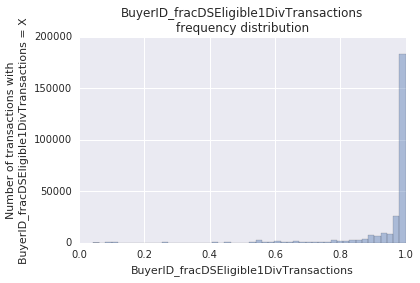

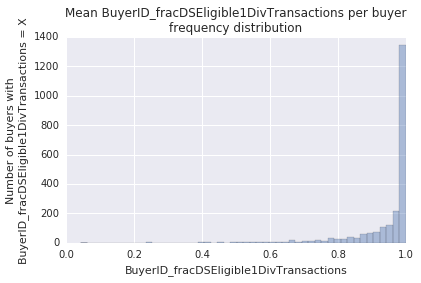

################################################################################
Feature: BuyerID_fracReturned1DivReturnedNotNull


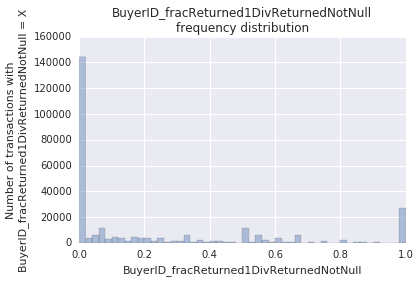

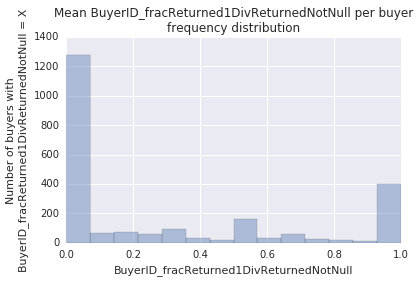

################################################################################
Feature: BuyerID_fracReturnedNotNullDivDSEligible1


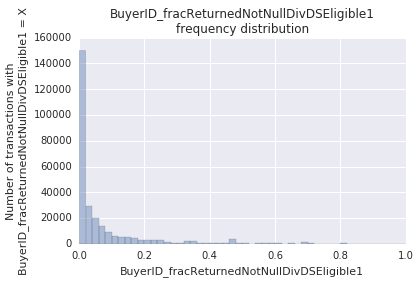

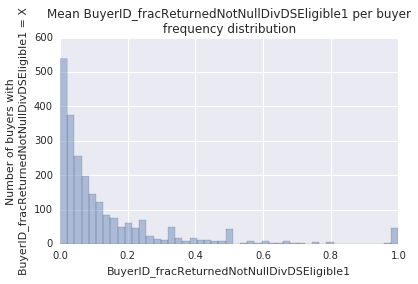

################################################################################
Feature: BuyerID_fracReturnedasm1DivTransactions


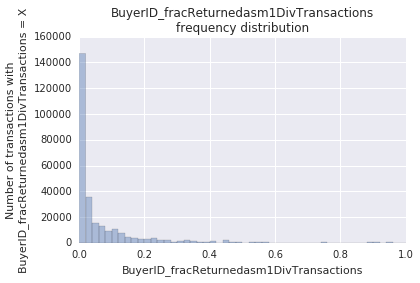

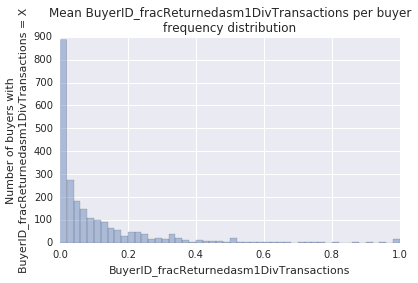

################################################################################
Feature: BuyerID_numDSEligible1


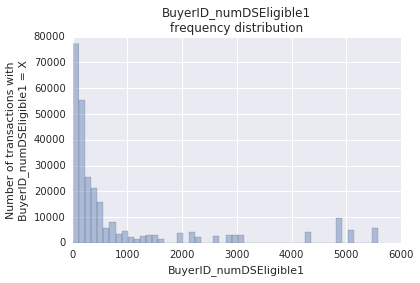

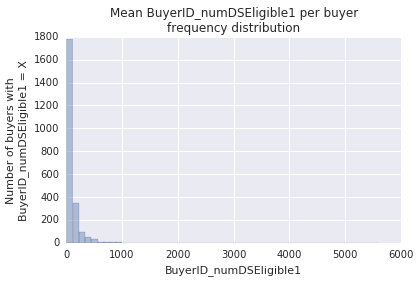

################################################################################
Feature: BuyerID_numReturned1


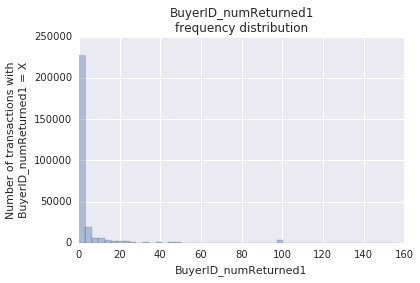

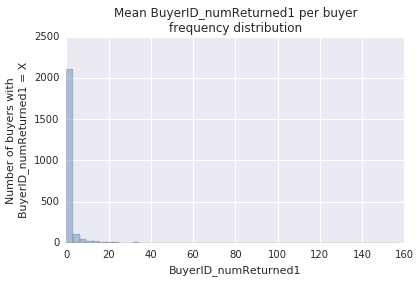

################################################################################
Feature: BuyerID_numReturnedNotNull


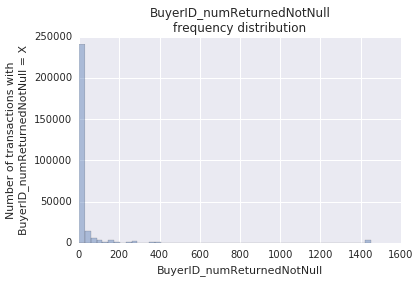

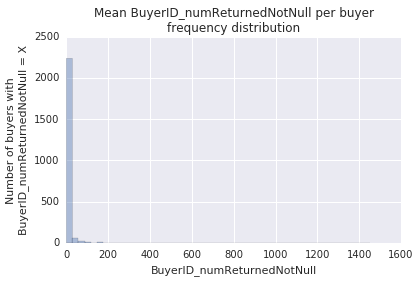

################################################################################
Feature: BuyerID_numReturnedasm1


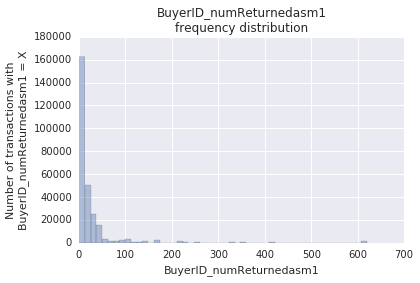

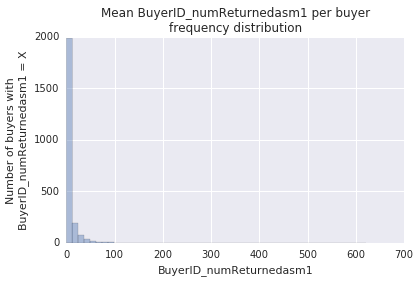

################################################################################
Feature: BuyerID_numTransactions


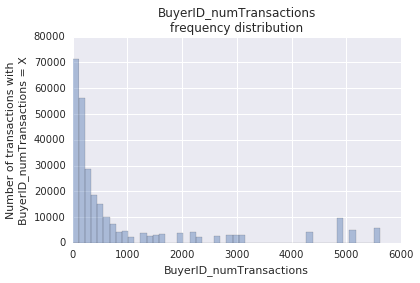

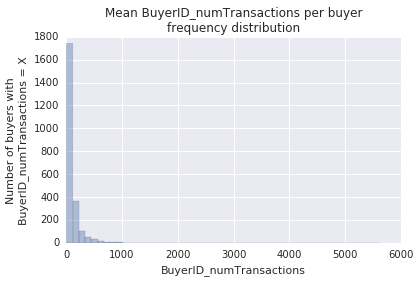

################################################################################
Feature: CarMake_fracDSEligible1DivTransactions


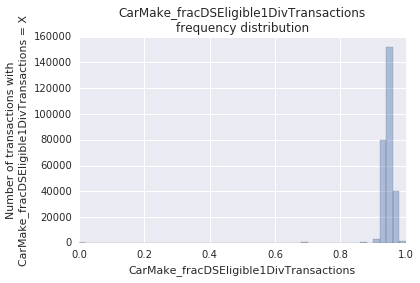

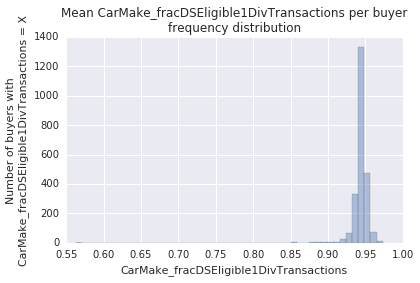

################################################################################
Feature: CarMake_fracReturned1DivReturnedNotNull


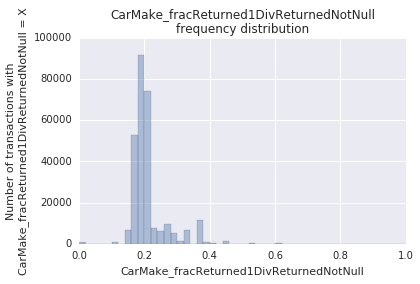

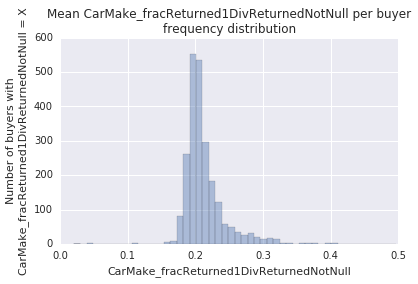

################################################################################
Feature: CarMake_fracReturnedNotNullDivDSEligible1


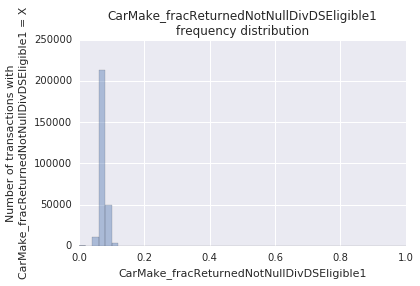

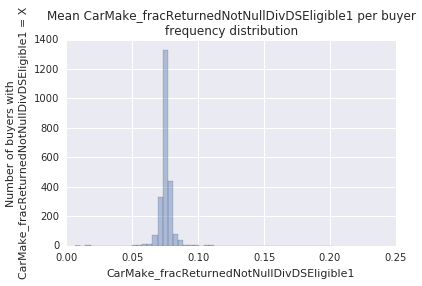

################################################################################
Feature: CarMake_fracReturnedasm1DivTransactions


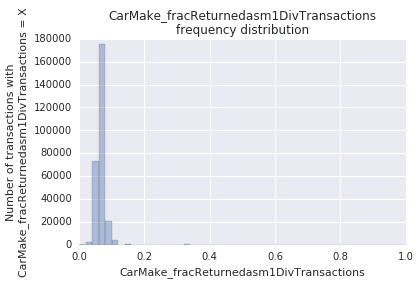

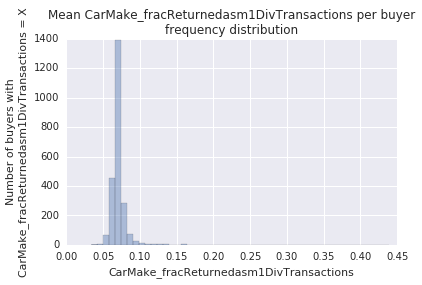

################################################################################
Feature: CarMake_numDSEligible1


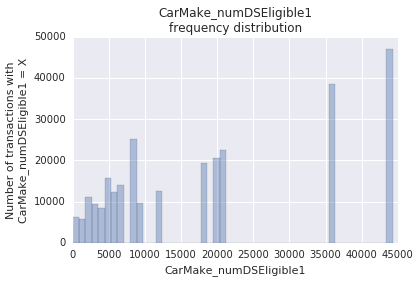

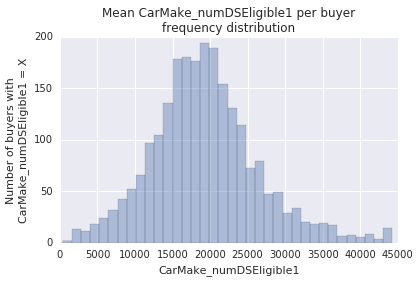

################################################################################
Feature: CarMake_numReturned1


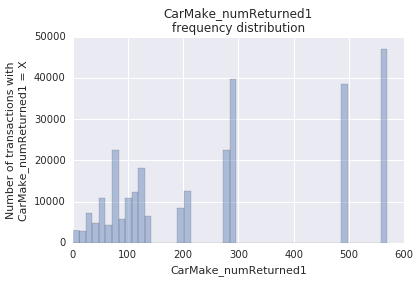

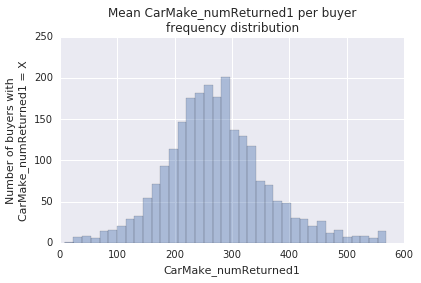

################################################################################
Feature: CarMake_numReturnedNotNull


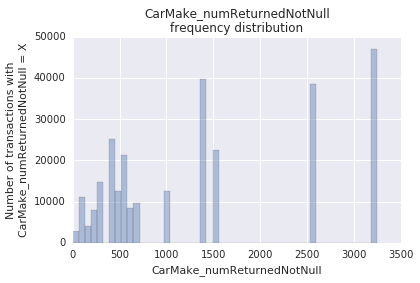

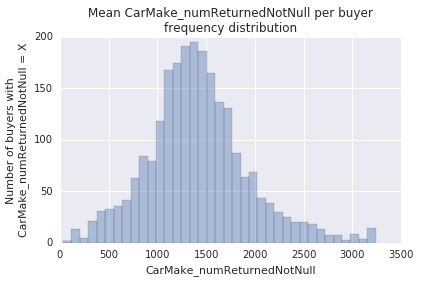

################################################################################
Feature: CarMake_numReturnedasm1


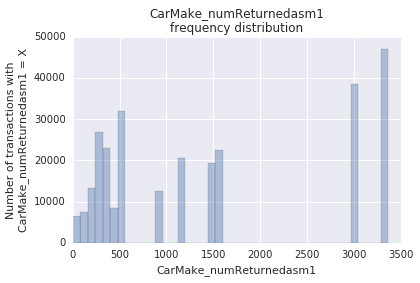

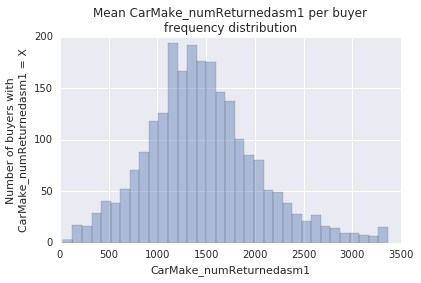

################################################################################
Feature: CarMake_numTransactions


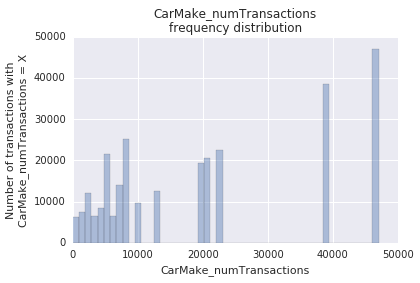

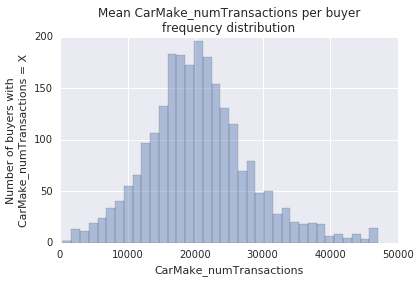

################################################################################
Feature: CarYear


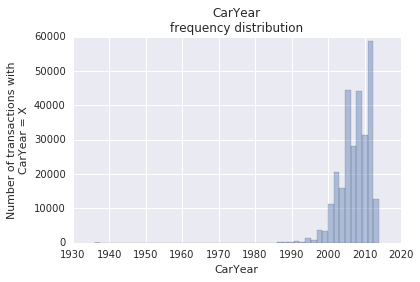

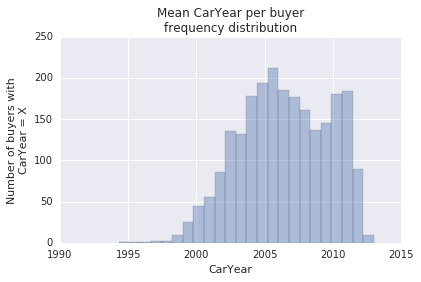

################################################################################
Feature: ConditionReport


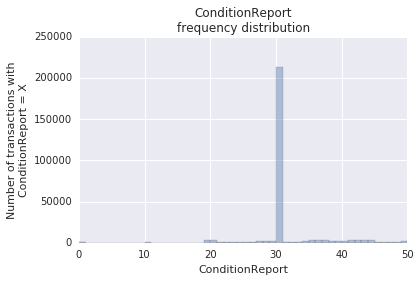

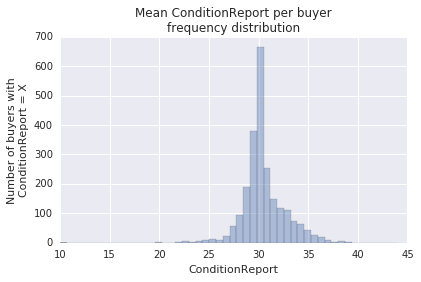

################################################################################
Feature: DSEligible


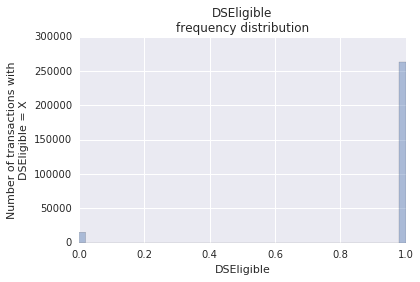

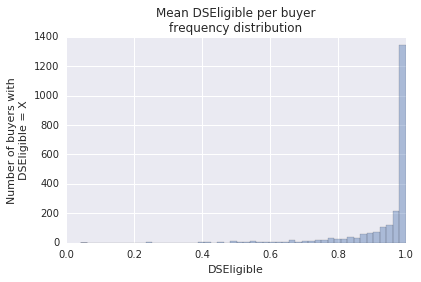

################################################################################
Feature: InLane


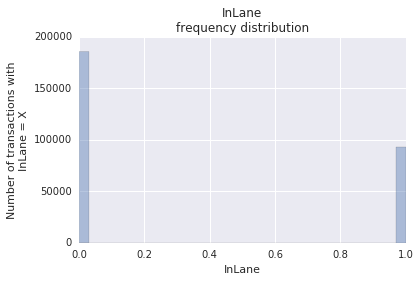

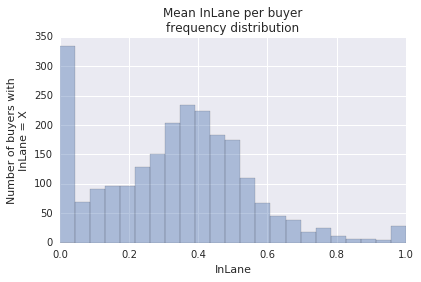

################################################################################
Feature: JDPowersCat_COMPACTCAR


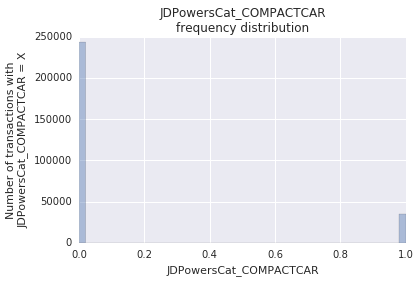

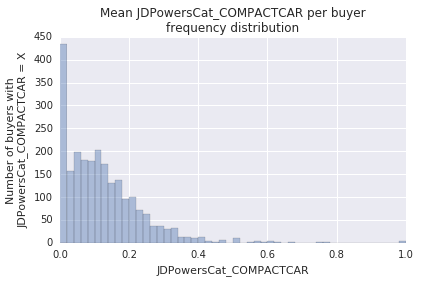

################################################################################
Feature: JDPowersCat_EXCLUDED


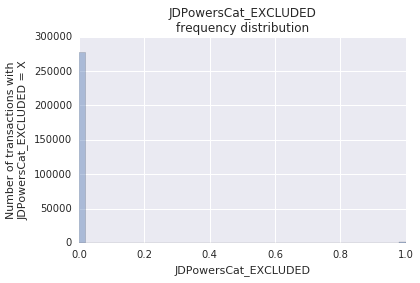

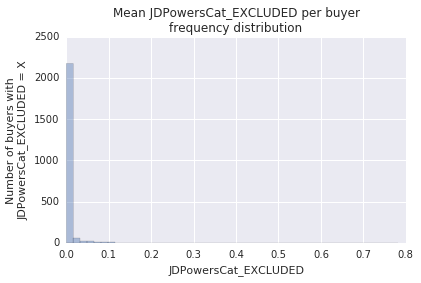

################################################################################
Feature: JDPowersCat_FULLSIZECAR


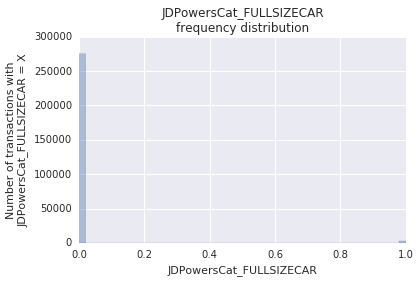

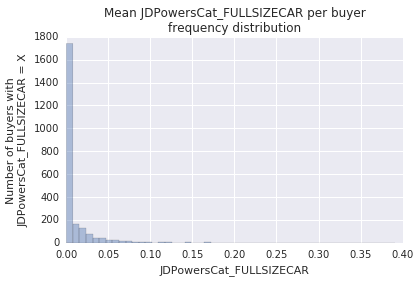

################################################################################
Feature: JDPowersCat_LUXURYCAR


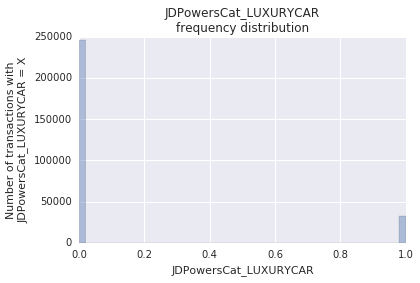

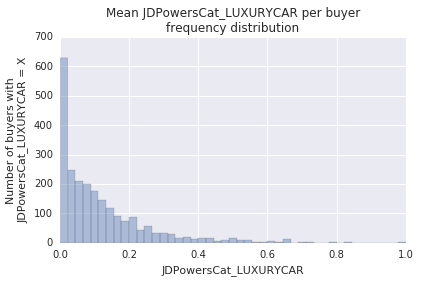

################################################################################
Feature: JDPowersCat_MIDSIZECAR


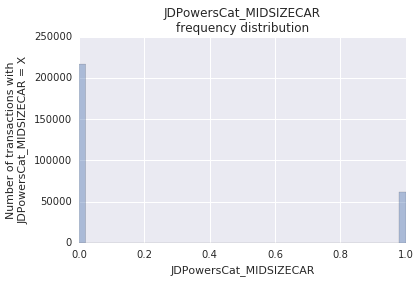

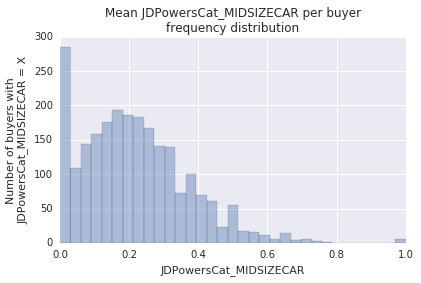

################################################################################
Feature: JDPowersCat_PICKUP


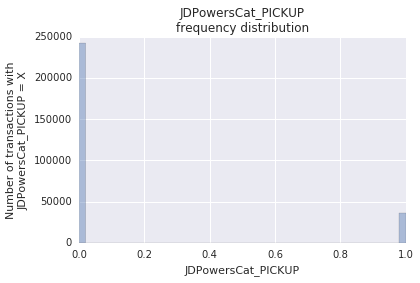

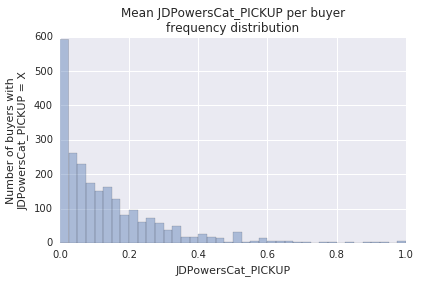

################################################################################
Feature: JDPowersCat_SPORTSCAR


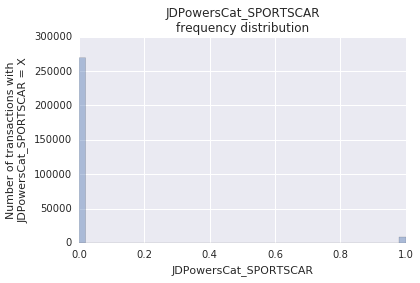

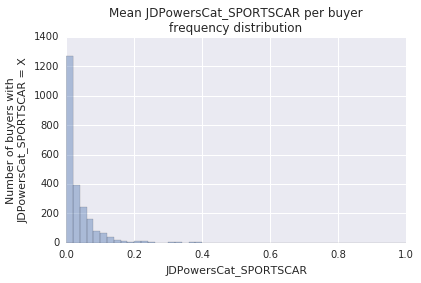

################################################################################
Feature: JDPowersCat_SUV


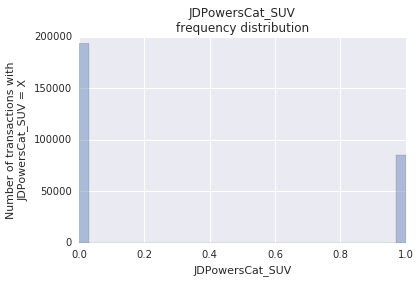

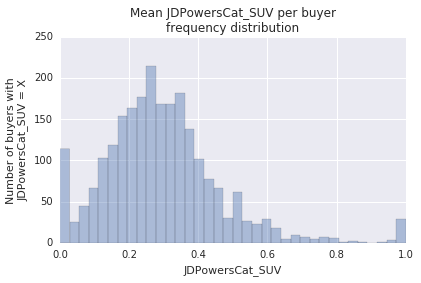

################################################################################
Feature: JDPowersCat_UNKNOWN


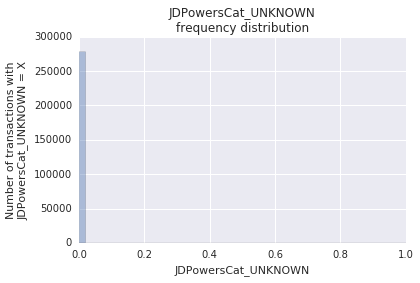

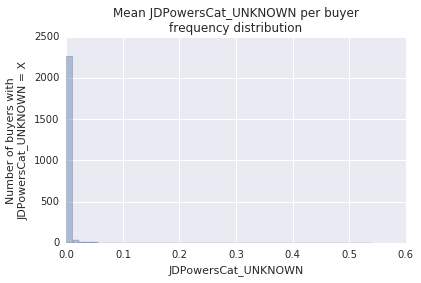

################################################################################
Feature: JDPowersCat_VAN


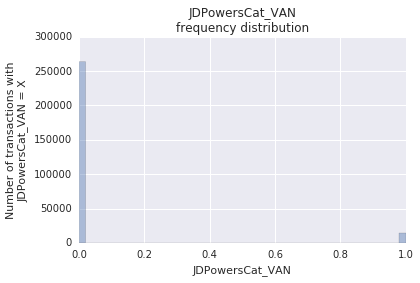

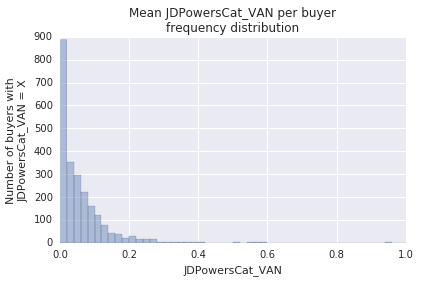

################################################################################
Feature: JDPowersCat_fracDSEligible1DivTransactions


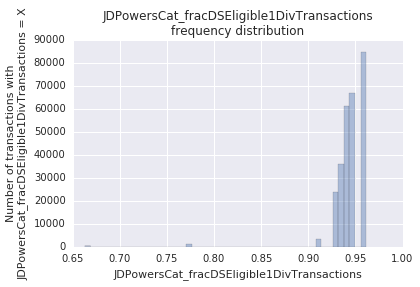

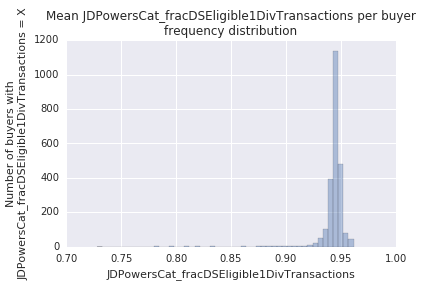

################################################################################
Feature: JDPowersCat_fracReturned1DivReturnedNotNull


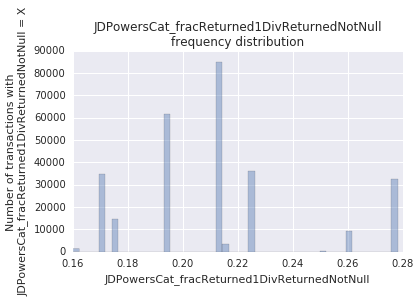

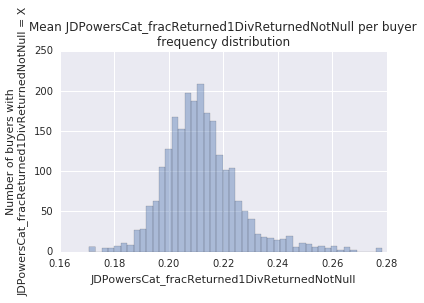

################################################################################
Feature: JDPowersCat_fracReturnedNotNullDivDSEligible1


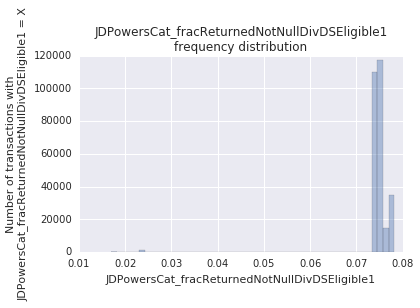

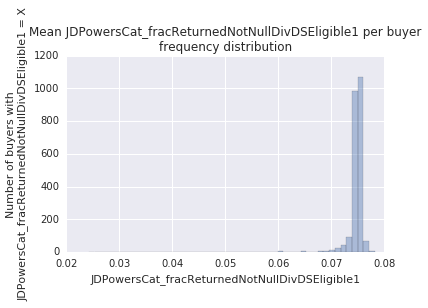

################################################################################
Feature: JDPowersCat_fracReturnedasm1DivTransactions


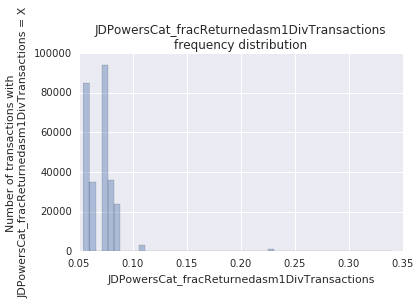

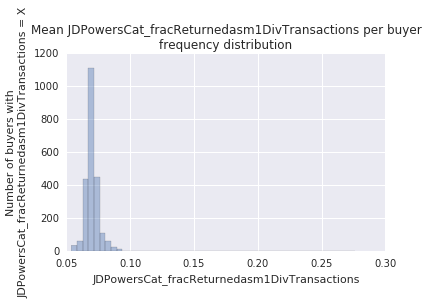

################################################################################
Feature: JDPowersCat_numDSEligible1


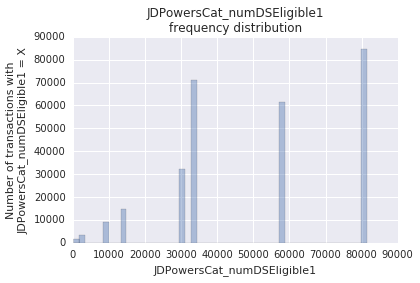

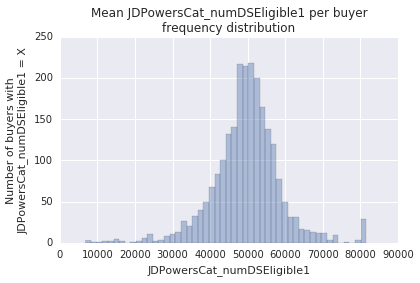

################################################################################
Feature: JDPowersCat_numReturned1


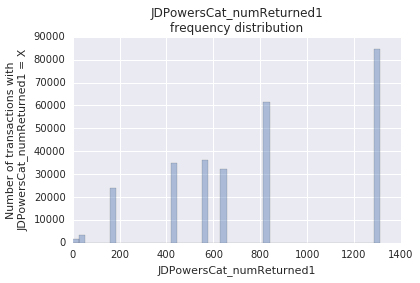

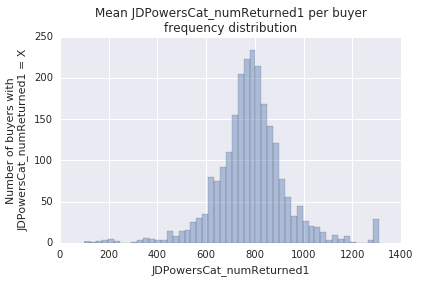

################################################################################
Feature: JDPowersCat_numReturnedNotNull


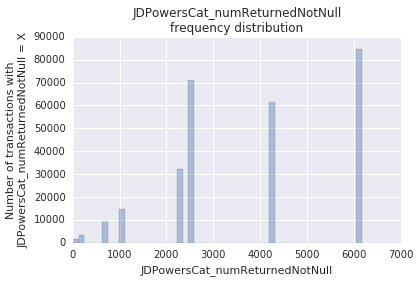

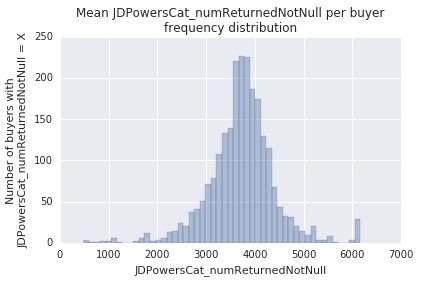

################################################################################
Feature: JDPowersCat_numReturnedasm1


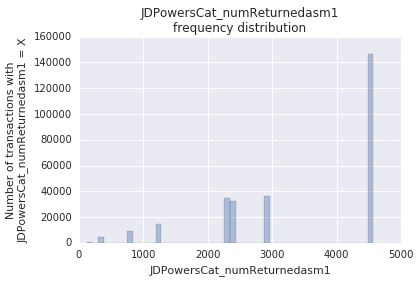

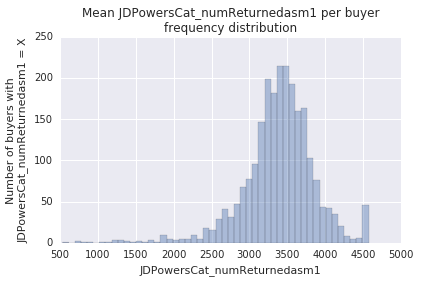

################################################################################
Feature: JDPowersCat_numTransactions


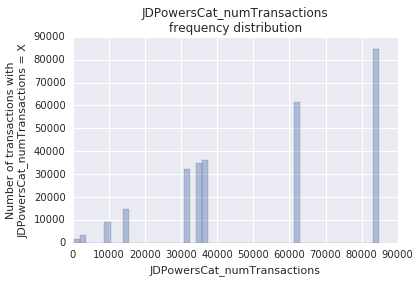

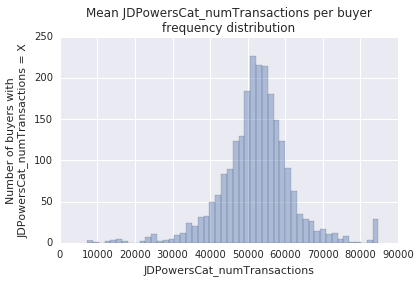

################################################################################
Feature: LIGHTG


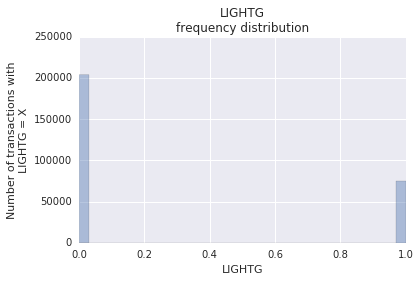

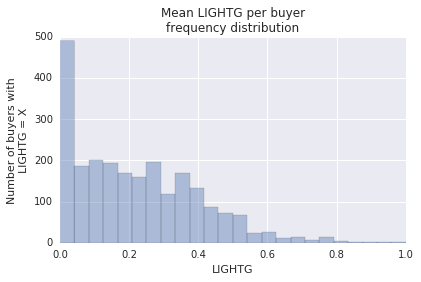

################################################################################
Feature: LIGHTR


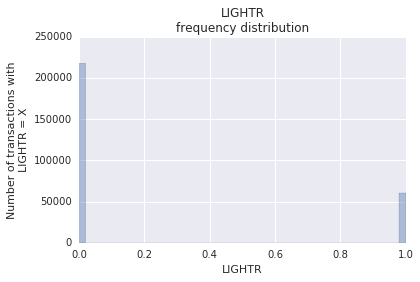

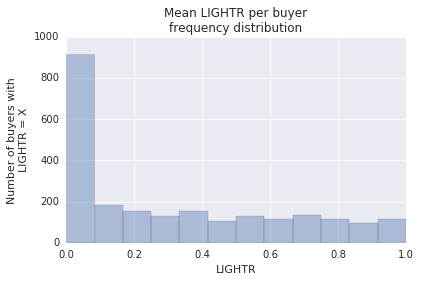

################################################################################
Feature: LIGHTY


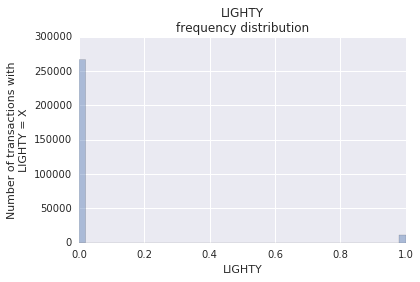

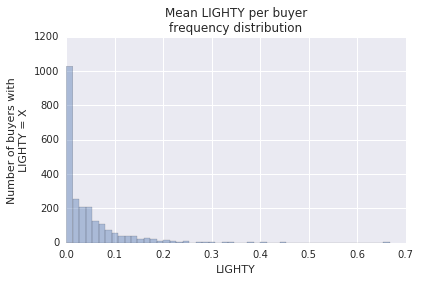

################################################################################
Feature: LIGHT_N0G1Y2R3


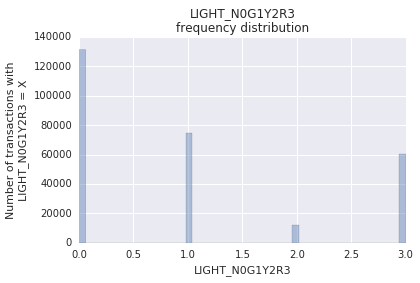

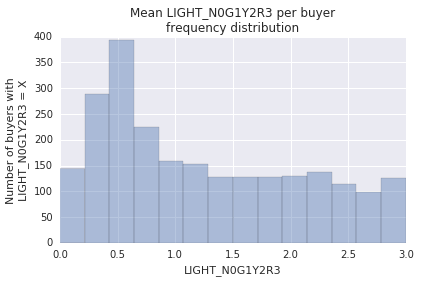

################################################################################
Feature: MMR


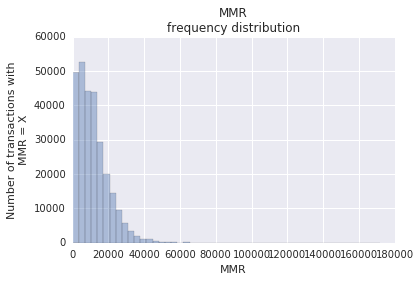

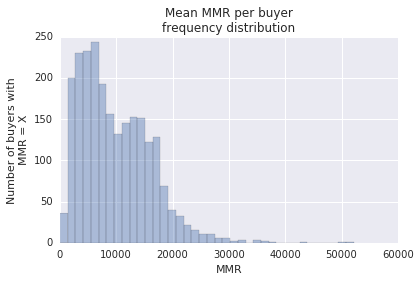

################################################################################
Feature: Mileage


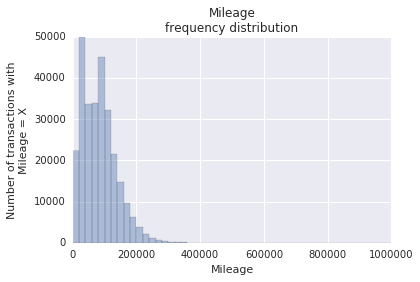

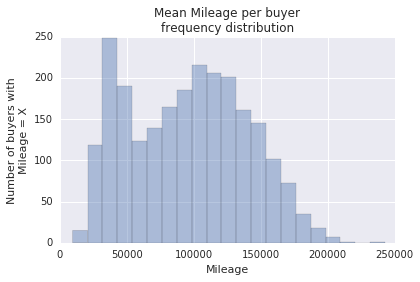

################################################################################
Feature: OVE


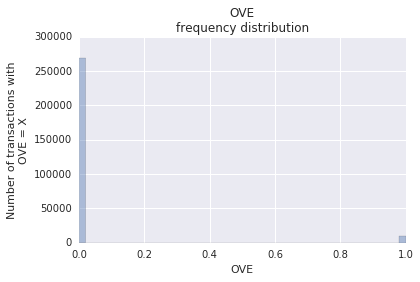

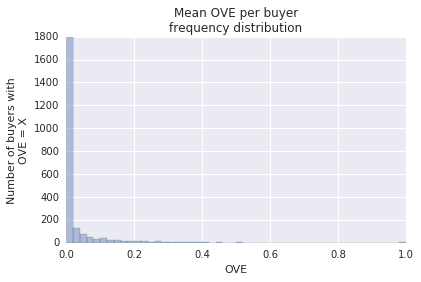

################################################################################
Feature: PSI


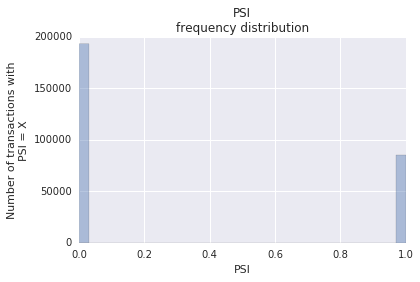

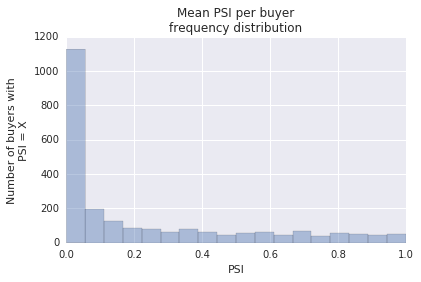

################################################################################
Feature: PSIEligible


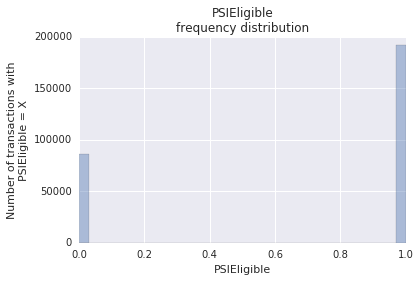

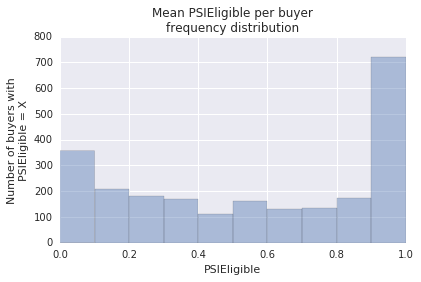

################################################################################
Feature: Returned


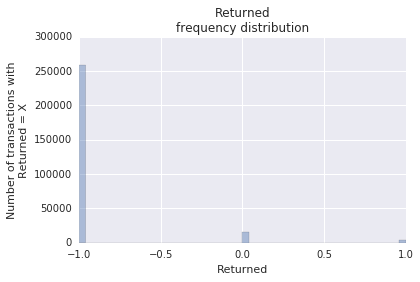

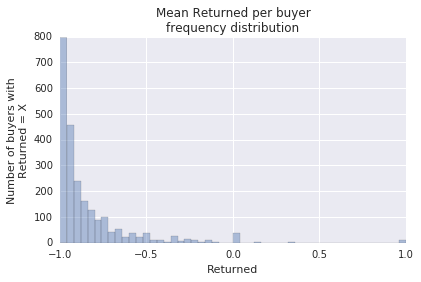

################################################################################
Feature: Returned_asm


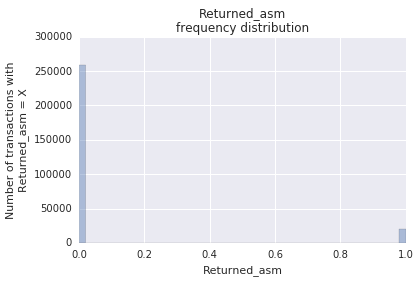

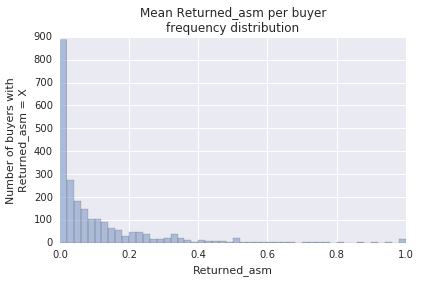

################################################################################
Feature: SaleDate_day


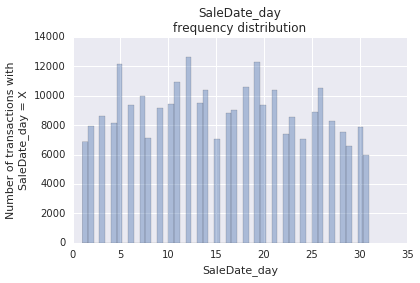

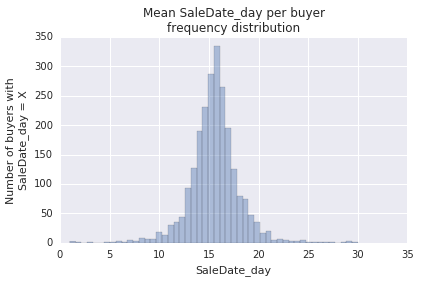

################################################################################
Feature: SaleDate_decyear


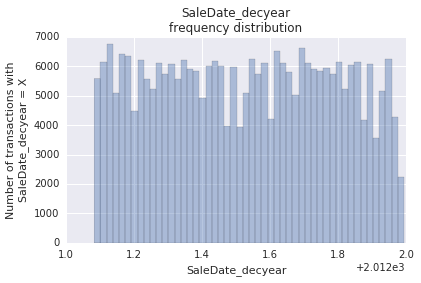

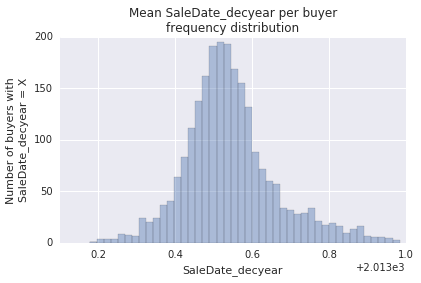

################################################################################
Feature: SaleDate_dow


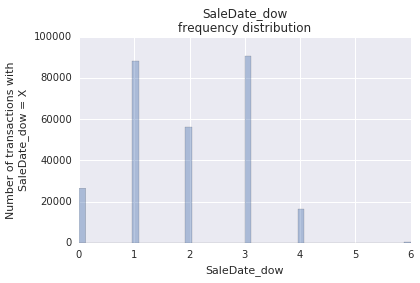

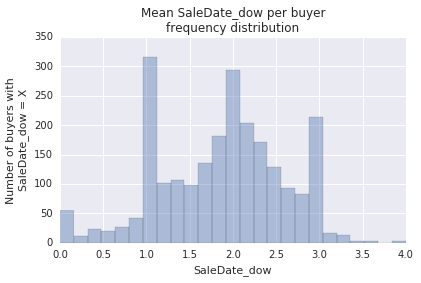

################################################################################
Feature: SaleDate_doy


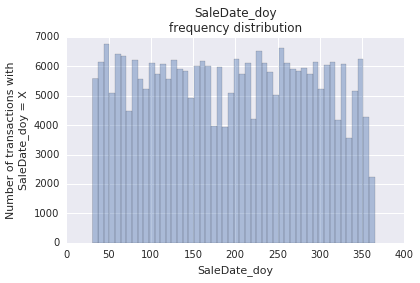

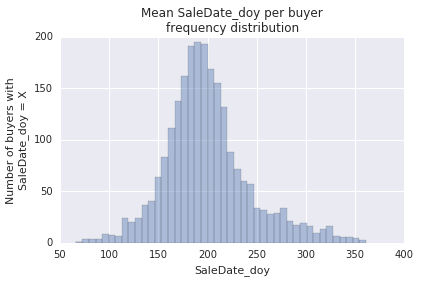

################################################################################
Feature: SalePrice


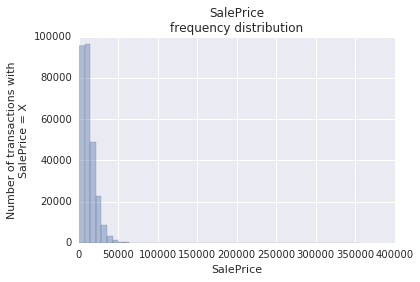

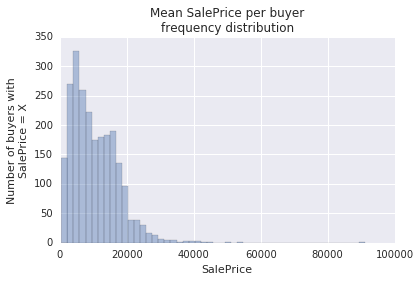

################################################################################
Feature: Salvage


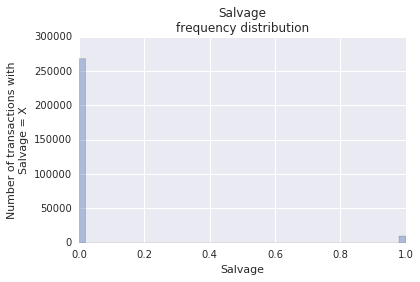

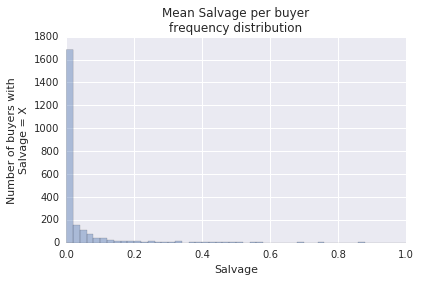

################################################################################
Feature: SellerID_fracDSEligible1DivTransactions


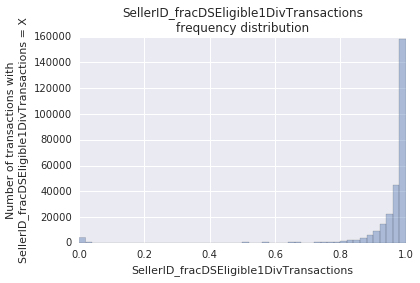

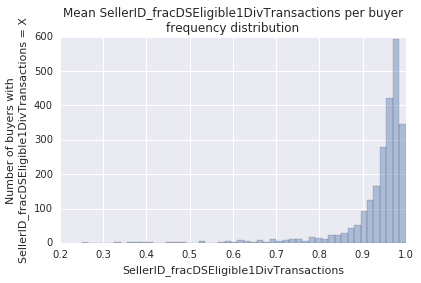

################################################################################
Feature: SellerID_fracReturned1DivReturnedNotNull


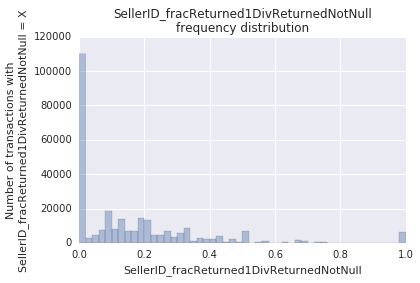

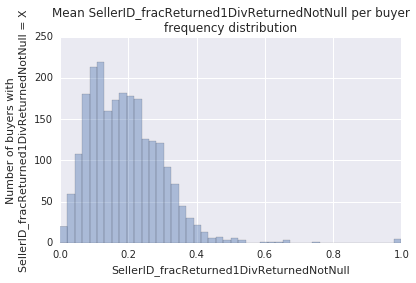

################################################################################
Feature: SellerID_fracReturnedNotNullDivDSEligible1


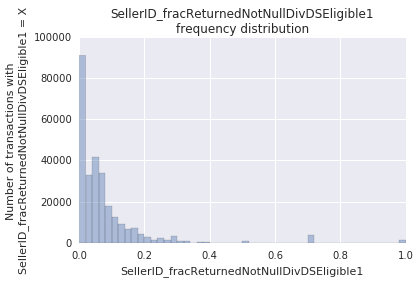

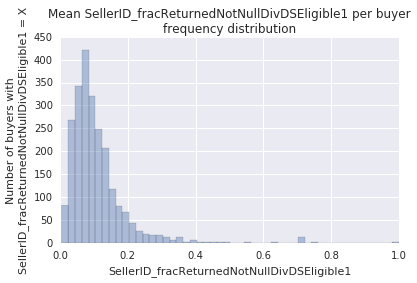

################################################################################
Feature: SellerID_fracReturnedasm1DivTransactions


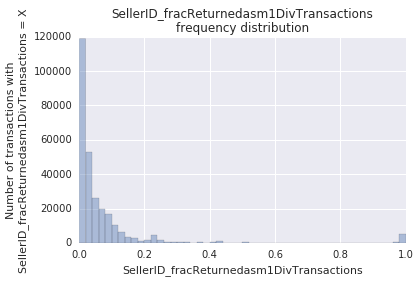

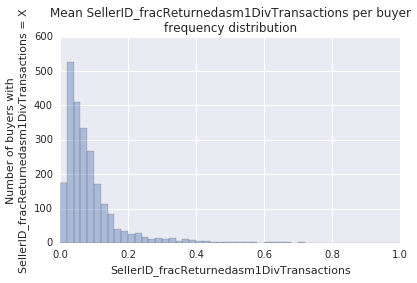

################################################################################
Feature: SellerID_numDSEligible1


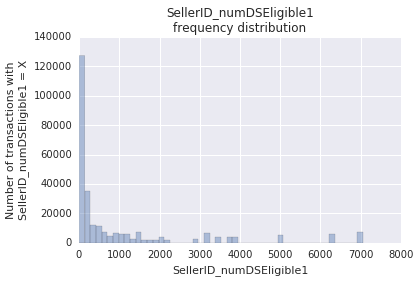

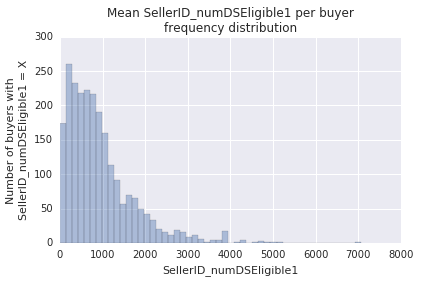

################################################################################
Feature: SellerID_numReturned1


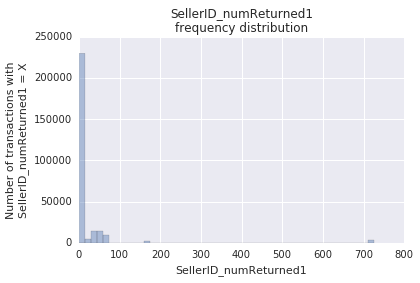

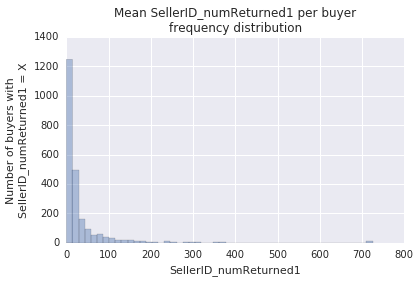

################################################################################
Feature: SellerID_numReturnedNotNull


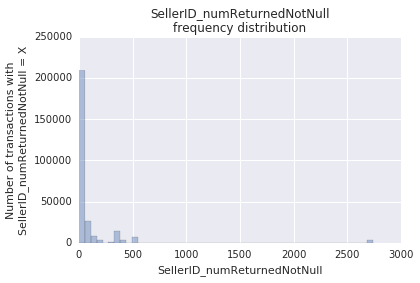

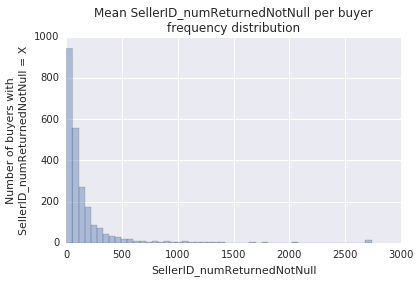

################################################################################
Feature: SellerID_numReturnedasm1


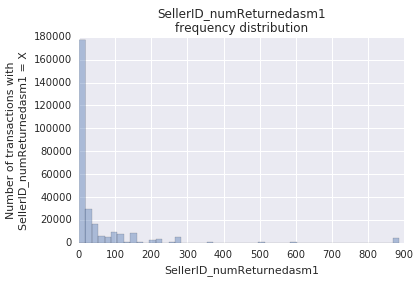

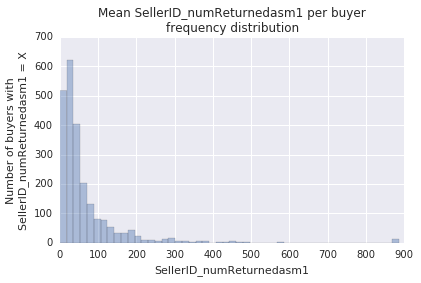

################################################################################
Feature: SellerID_numTransactions


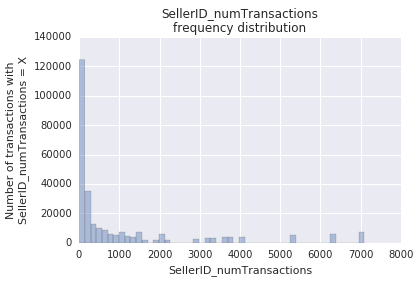

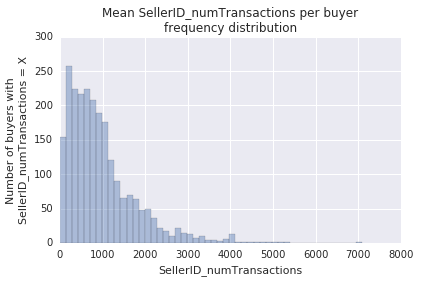

################################################################################
Feature: SellingLocation_fracDSEligible1DivTransactions


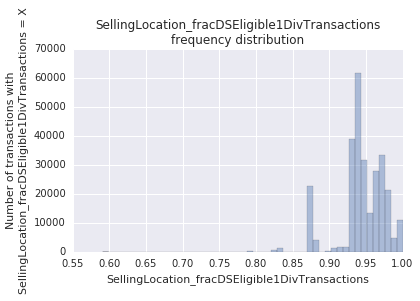

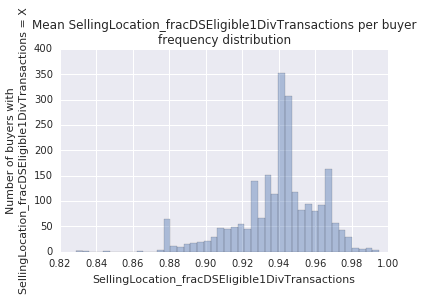

################################################################################
Feature: SellingLocation_fracReturned1DivReturnedNotNull


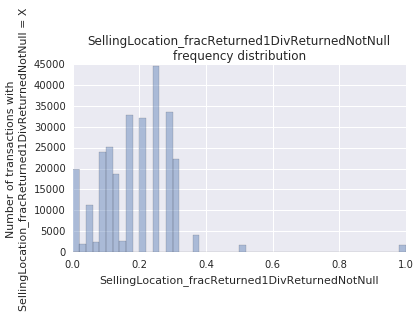

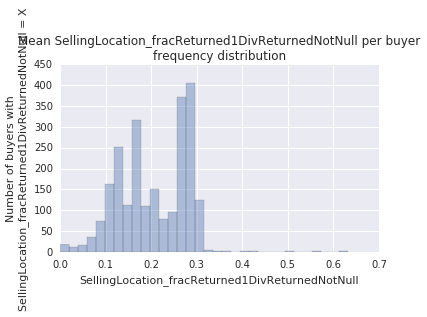

################################################################################
Feature: SellingLocation_fracReturnedNotNullDivDSEligible1


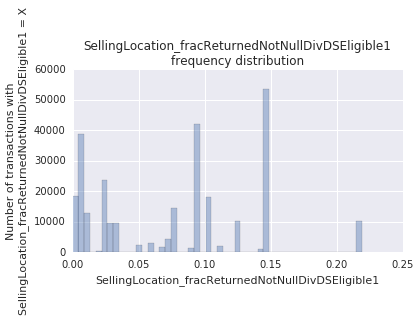

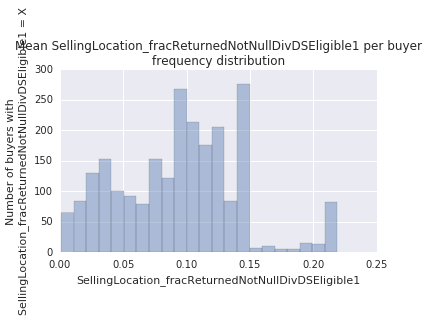

################################################################################
Feature: SellingLocation_fracReturnedasm1DivTransactions


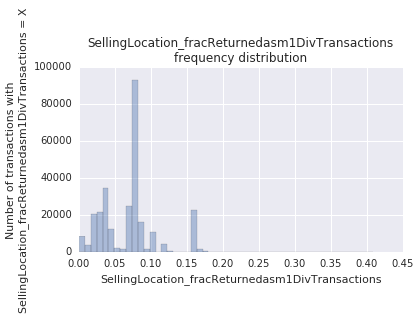

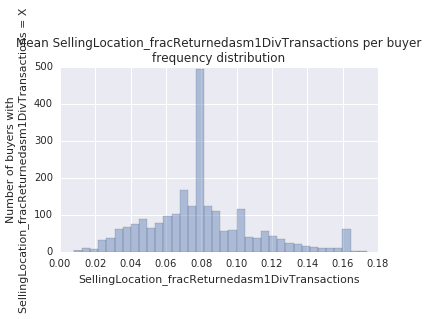

################################################################################
Feature: SellingLocation_lat


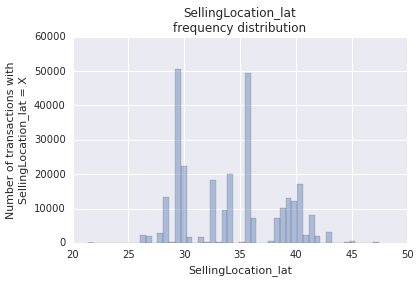

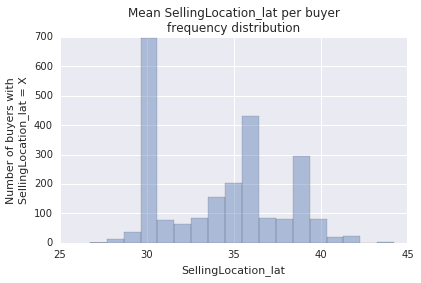

################################################################################
Feature: SellingLocation_lon


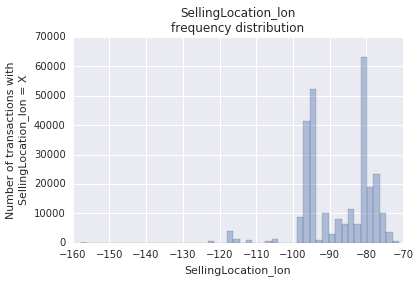

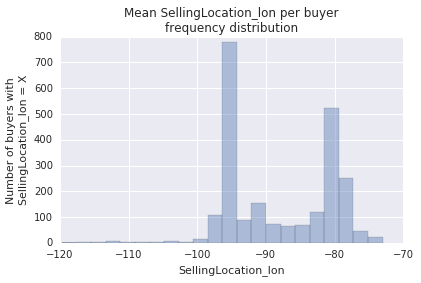

################################################################################
Feature: SellingLocation_numDSEligible1


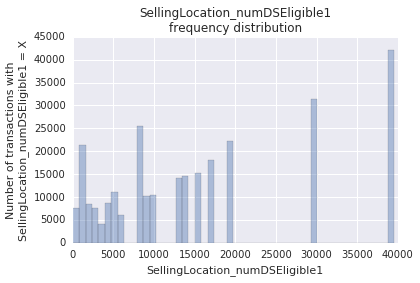

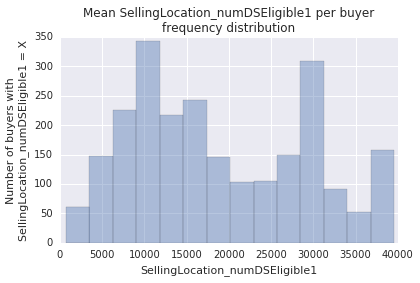

################################################################################
Feature: SellingLocation_numReturned1


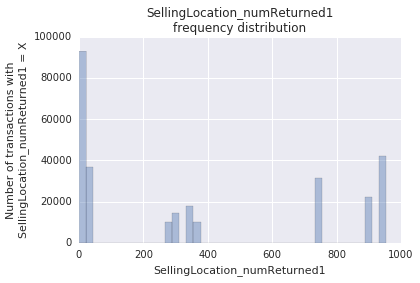

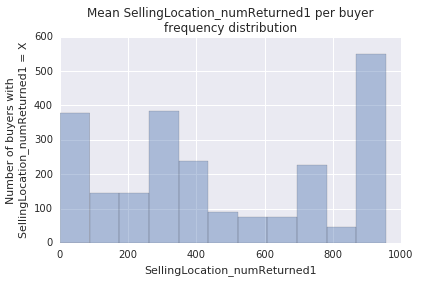

################################################################################
Feature: SellingLocation_numReturnedNotNull


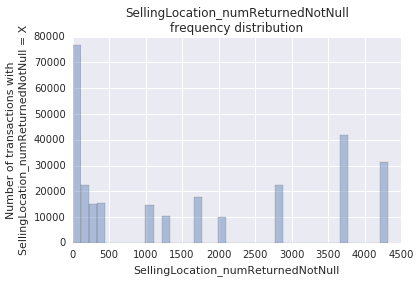

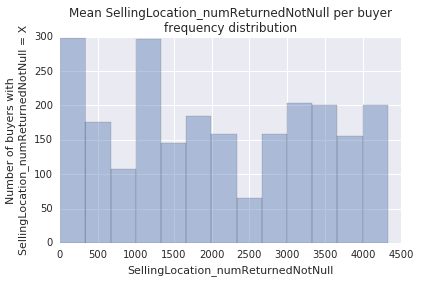

################################################################################
Feature: SellingLocation_numReturnedasm1


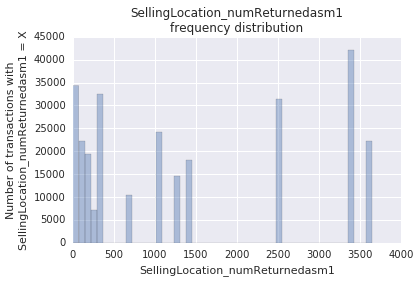

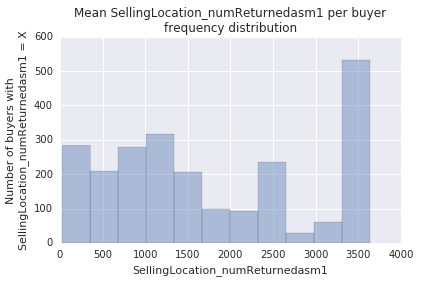

################################################################################
Feature: SellingLocation_numTransactions


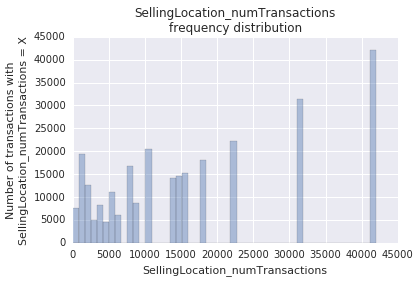

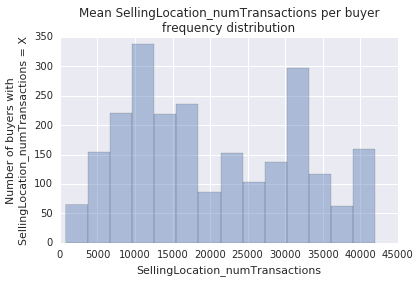

################################################################################
Feature: Simulcast


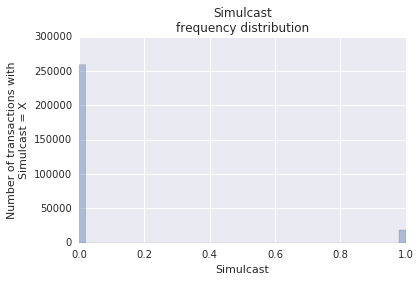

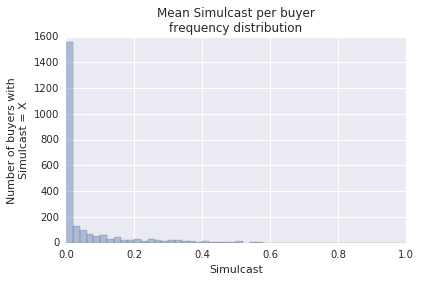

################################################################################
Feature: VIN_fracDSEligible1DivTransactions


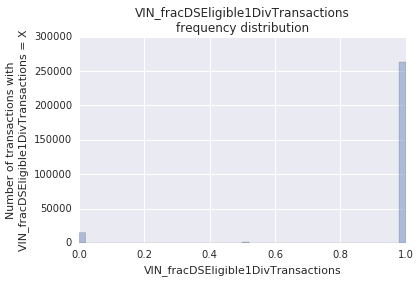

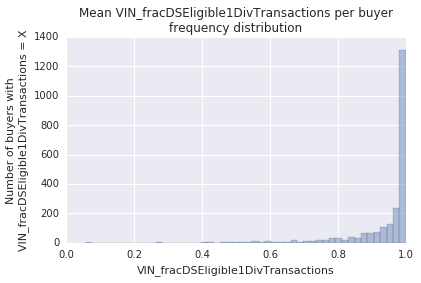

################################################################################
Feature: VIN_fracReturned1DivReturnedNotNull


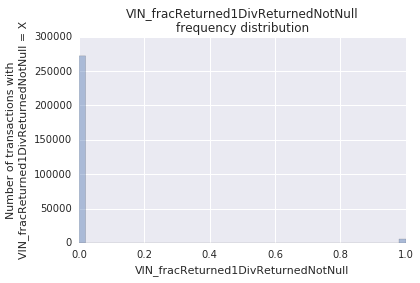

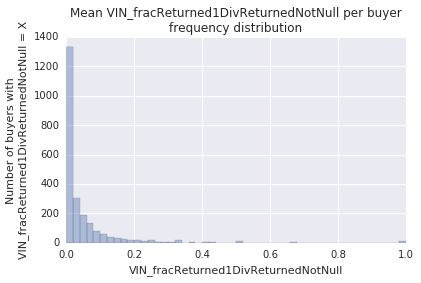

################################################################################
Feature: VIN_fracReturnedNotNullDivDSEligible1


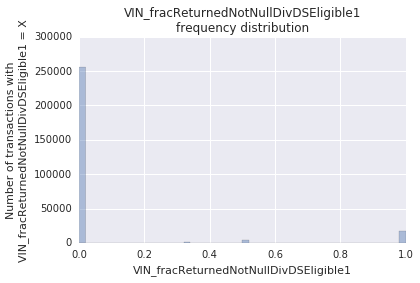

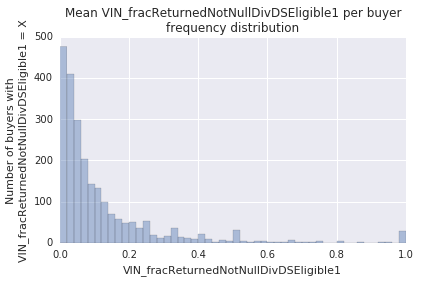

################################################################################
Feature: VIN_fracReturnedasm1DivTransactions


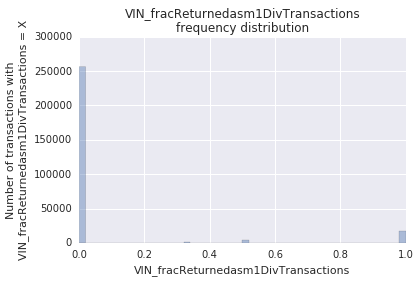

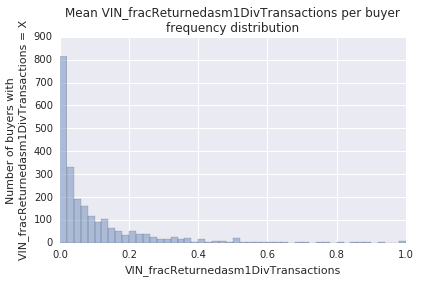

################################################################################
Feature: VIN_numDSEligible1


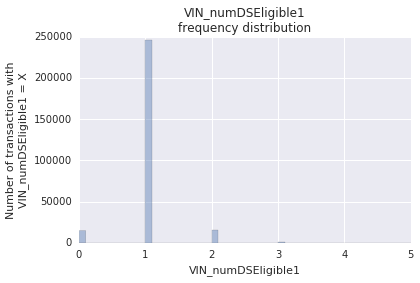

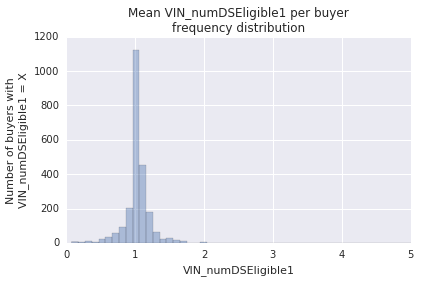

################################################################################
Feature: VIN_numReturned1


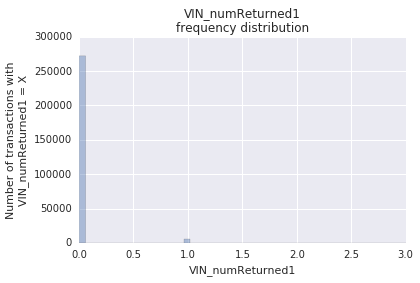

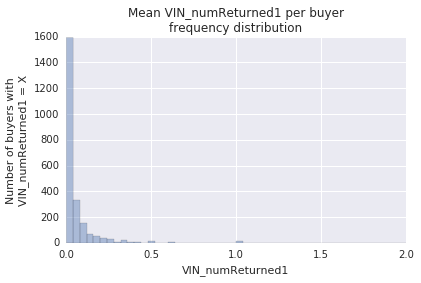

################################################################################
Feature: VIN_numReturnedNotNull


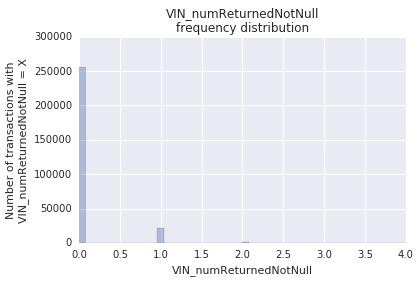

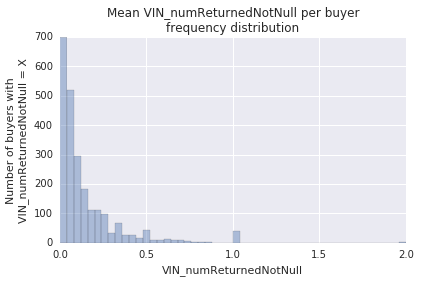

################################################################################
Feature: VIN_numReturnedasm1


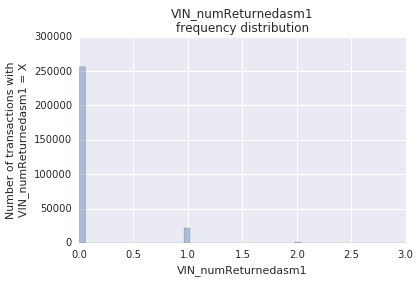

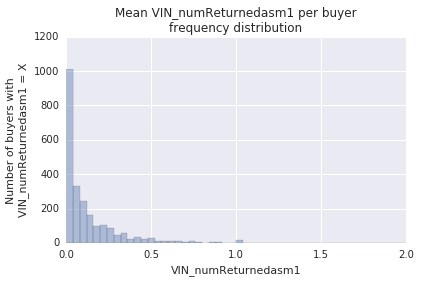

################################################################################
Feature: VIN_numTransactions


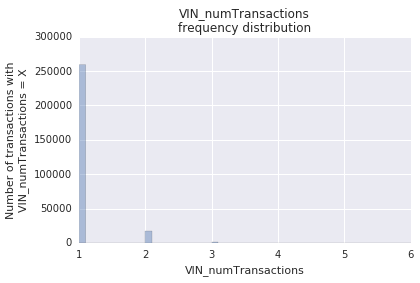

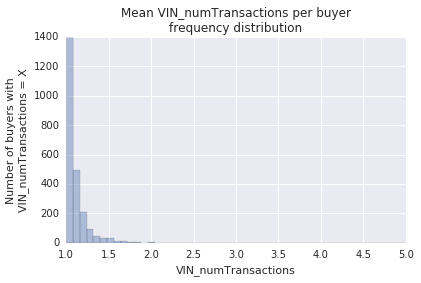

In [22]:
# re-initialize matplotlib inline in case handle dropped
%matplotlib inline
demo.app_predict.predict.plot_freq_dists(
    df=df,
    columns=sorted(df.columns[np.logical_or(df.dtypes=='int64', df.dtypes=='float64')]),
    path_plot_dir=os.path.join(path_data_dir, 'plot_freq_dists'))

## Heuristic

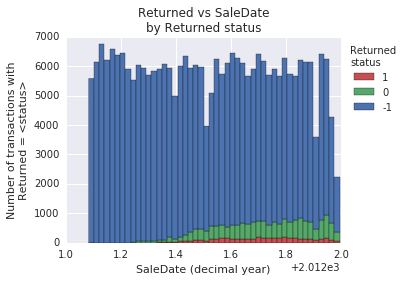

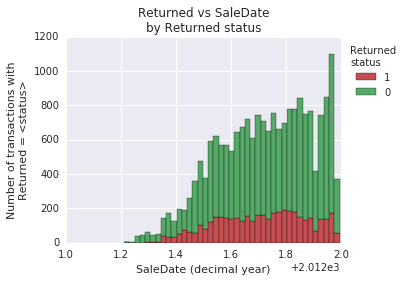

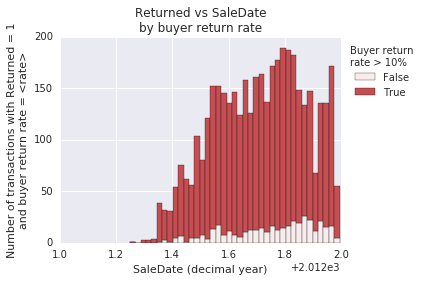

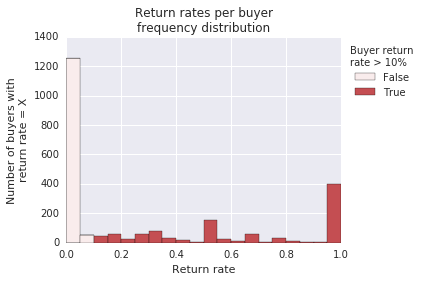

In [23]:
# re-initialize matplotlib inline in case handle dropped
%matplotlib inline
demo.app_predict.predict.plot_heuristic(
    df=df,
    path_plot_dir=os.path.join(path_data_dir, 'plot_heuristic'))

### Test heuristic
Note: The heuristic isn't "trained", just calculated (no iterations).
TODO:
* Bootstrap to get uncertainties.

In [80]:
# Increased return status starts ~2013.4 ~ Jun 2013
# len(df)/2 ~ 140K

In [81]:
df = df_orig.copy()
df['SaleDate'] = pd.to_datetime(df['SaleDate'], format=r'%y-%m-%d')
df.sort_values(by=['SaleDate', 'BuyerID', 'SellerID', 'VIN'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.columns

Index(['BuyerID', 'SellerID', 'Mileage', 'VIN', 'SellingLocation', 'CarMake',
       'SalePrice', 'CarYear', 'MMR', 'JDPowersCat', 'LIGHTG', 'LIGHTY',
       'LIGHTR', 'PSI', 'Arbitrated', 'Salvage', 'OVE', 'Simulcast', 'InLane',
       'PSIEligible', 'SaleDate', 'Autocheck_score', 'ConditionReport',
       'DSEligible', 'Returned'],
      dtype='object')

In [85]:
buyer_retrate = 'BuyerID_fracReturned1DivReturnedNotNull'
buyer_retrate_max = 0.1

In [157]:
date_range = pd.date_range(start=df['SaleDate'].min(), end=df['SaleDate'].max(), freq='M')
saledate_train_min = date_range[0]
saledate_test_min = saledate_train_min
saledate_eval_min = saledate_train_min
for idx in range(4, len(date_range)-1):
    # Define data sets.    
    saledate_train_max = date_range[idx]
    saledate_test_max = date_range[idx+1]
    saledate_eval_max = saledate_test_max
    print('Data set dates:')
    print('train:', saledate_train_min.isoformat(), saledate_train_max.isoformat())
    print('test: ', saledate_test_min.isoformat(), saledate_test_max.isoformat())
    print('eval: ', saledate_eval_min.isoformat(), saledate_eval_max.isoformat())
    df_train = df.loc[
        np.logical_and(
            saledate_train_min <= df['SaleDate'],
            df['SaleDate'] < saledate_train_max)].copy()
    df_test = df.loc[
        np.logical_and(
            saledate_test_min <= df['SaleDate'],
            df['SaleDate'] < saledate_test_max)].copy()
    df_eval = df.loc[
        np.logical_and(
            saledate_eval_min <= df['SaleDate'],
            df['SaleDate'] < saledate_eval_max)].copy()
    # Prohibit purchase of DealShield in test data:
    # If prohibiting purchase of DealShield,
    # then DSEligible = 0, Returned = np.nan (null)
    df_train = demo.app_predict.predict.eta(df=df_train, path_data_dir=path_data_dir)
    buyers_prohibited = df_train.loc[df_train[buyer_retrate] > buyer_retrate_max, 'BuyerID'].unique()
    print("Number of buyers prohibited =", len(buyers_prohibited))
    tfmask = np.logical_and(
        df_test['SaleDate'] > df_train['SaleDate'].max(),
        df_test['BuyerID'].isin(buyers_prohibited))
    print(sum(tfmask))
    # tfmask = df_train[buyer_retrate] > buyer_retrate_max
    # print(sum(tfmask))
    tfmask = df_test['DSEligible'] == 1
    print(sum(tfmask))
    transactions_affected = df_test.loc[tfmask]
    df_test.loc[tfmask, 'DSEligible'] = 0
    df_test.loc[tfmask, 'Returned'] = np.nan
    print("Number of transactions affected =", len(transactions_affected))
    
    break

Data set dates:
train: 2013-01-31T00:00:00 2013-05-31T00:00:00
test:  2013-01-31T00:00:00 2013-06-30T00:00:00
eval:  2013-01-31T00:00:00 2013-06-30T00:00:00
Number of buyers prohibited = 101
0
121591
Number of transactions affected = 121591


In [159]:
np.logical_and(
        df_test['SaleDate'] > df_train['SaleDate'].max(),
        df_test['BuyerID'].isin(buyers_prohibited)).any()

False

In [154]:
    df_test = demo.app_predict.predict.eta(df=df_test, path_data_dir=path_data_dir)
    df_eval = demo.app_predict.predict.eta(df=df_eval, path_data_dir=path_data_dir)

    # Evaluate return rates
    print('Return rates:')
    print('df_train:', sum(df_train['Returned']==1)/sum(df_train['Returned']!=-1))
    print('df_test: ', sum(df_test['Returned']==1)/sum(df_test['Returned']!=-1))
    print('df_eval: ', sum(df_eval['Returned']==1)/sum(df_eval['Returned']!=-1))
    
    print()
    break

Data set dates:
train: 2013-01-31T00:00:00 2013-05-31T00:00:00
test:  2013-01-31T00:00:00 2013-06-30T00:00:00
eval:  2013-01-31T00:00:00 2013-06-30T00:00:00
Number of buyers prohibited = 101
> <ipython-input-154-70f818120063>(41)<module>()
-> transactions_affected = df_test.loc[tfmask]
(Pdb) tfmask
0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
128445    False
128446    False
128447    False
128448    False
128449    False
128450    False
128451    False
128452    False
128453    False
128454    False
128455    False
128456    False
128457    Fa

BdbQuit: 

In [128]:
buyers_prohibited

array(['22902', '36633', '40246', '52306', '69154', '82444', '88434',
       '92311', '100324', '106829', '116561', '173709', '182883', '199601',
       '212900', '229151', '229366', '235345', '249533', '270214',
       '284412', '291657', '341974', '344604', '65545', '31518', '42973',
       '168786', '223541', '242080', '19092', '19332', '20481', '24900',
       '46589', '46857', '50602', '62983', '76939', '79918', '119493',
       '171094', '172700', '176870', '206392', '207552', '213829',
       '242784', '282672', '342112', '312865', '18746', '29116', '29783',
       '77493', '95456', '137859', '230246', '257977', '261712', '20718',
       '251827', '26139', '28958', '30192', '179863', '303851', '339858',
       '138709', '82949', '87548', '101770', '164237', '265419', '148095',
       '24511', '57242', '226749', '241540', '59242', '62851', '16640',
       '31036', '49734', '163743', '42309', '248009', '250430', '284232',
       '58584', '13427', '12743', '13752', '61773', '32407'

In [129]:
transactions_affected

,BuyerID,SellerID,Mileage,VIN,SellingLocation,CarMake,SalePrice,CarYear,MMR,JDPowersCat,...,Salvage,OVE,Simulcast,InLane,PSIEligible,SaleDate,Autocheck_score,ConditionReport,DSEligible,Returned


In [153]:
sum(tfmask)

0

In [144]:
test = df_test.loc[df_test['SaleDate'] > df_train['SaleDate'].max()]
print(len(test))
test = test.loc[df_test['BuyerID'].isin(buyers_prohibited)]
print(len(test))
test = test.loc[test['DSEligible'] == 1]
print(len(test))

24772
1486
1404


In [148]:
tfmask = np.logical_and(
    np.logical_and(
        df_test['SaleDate'] > df_train['SaleDate'].max(),
        df_test['BuyerID'].isin(buyers_prohibited)),
    df_test['DSEligible'] == 1)
sum(tfmask)


1404

In [151]:
df_test.loc[tfmask, ['BuyerID', 'SaleDate', 'DSEligible']]

,BuyerID,SaleDate,DSEligible
103791,82444,2013-05-31,1
103792,82444,2013-05-31,1
103793,82444,2013-05-31,1
104023,19332,2013-06-02,1
104079,31518,2013-06-03,1
104136,57242,2013-06-03,1
104137,57242,2013-06-03,1
104185,82444,2013-06-03,1
104186,82444,2013-06-03,1
104187,82444,2013-06-03,1


In [ ]:
# REDO BELOW

In [ ]:
# TODO
# Determine which features are categorical and plot.
# Features are considered "categorical" if
# num_unique_feature_values < min(num_unique_id_values, num_unique_target_values)
(df_ftrs, ds_trg) = (step.s2.dfs.df_features_model, step.s2.dfs.ds_target_model)
(nuniq_uid, nuniq_trg) = (len(df_ftrs['SERIALNO'].unique()), len(ds_trg.unique()))
nuniq_min = min(nuniq_uid, nuniq_trg)
(ftr_nuniq, nuniq_nftrs, cat_ftrs) = (dict(), collections.defaultdict(int), list())
for ftr in df_ftrs.columns:
    ftr_nuniq[ftr] = len(df_ftrs[ftr].unique())
for (ftr, nuniq) in ftr_nuniq.items():
    nuniq_nftrs[nuniq] += 1
    if 1 < nuniq < nuniq_min:
        cat_ftrs.append(ftr)
nuniq_nftrs = np.asarray(sorted(nuniq_nftrs.items()))
tfmask = np.logical_and(1 < nuniq_nftrs[:, 0], nuniq_nftrs[:, 0] < nuniq_min)
nuniq_nftrs_cat = nuniq_nftrs[tfmask]
if not np.sum(nuniq_nftrs_cat[:, 1]) == len(cat_ftrs):
    raise AssertionError(
        ("Program error. The tallies of categorical features do not match.\n" +
         "Required: np.sum(nuniq_nftrs_cat[:, 1]) == len(cat_ftrs)\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=np.sum(nuniq_nftrs_cat[:, 1]), rhs=len(cat_ftrs)))
print(
    ("Features are considered 'categorical' if num_unique_feature_values\n" +
     "    < min(num_unique_id_values ({uid}), num_unique_target_values ({trg}))\n" +
     "    = min({nuid}, {ntrg}) = {nmin}\n" +
     "Percent of features that are categorical: {frac:.1%}").format(
        uid='SERIALNO', trg=step.s0.dfs.ds_target_model.name,
        nuid=nuniq_uid, ntrg=nuniq_trg, nmin=nuniq_min,
        frac=len(cat_ftrs)/len(df_ftrs.columns)))
plt.semilogx(
    nuniq_nftrs[:, 0], nuniq_nftrs[:, 1], marker='.', linestyle='-',
    color=sns.color_palette()[0], label='features')
plt.semilogx(
    nuniq_nftrs_cat[:, 0], nuniq_nftrs_cat[:, 1], marker='o', linestyle='',
    color=sns.color_palette('dark')[0], label='categorical features')
plt.axvline(
    x=len(step.s2.dfs.ds_target_model.unique()),
    color=sns.color_palette()[1], label=step.s2.dfs.ds_target_model.name)
plt.axvline(
    x=len(step.s2.dfs.df_features_model['SERIALNO'].unique()),
    color=sns.color_palette()[2], label='SERIALNO')
plt.title("Number of feature vs number of unique values per feature")
plt.xlabel("Number of unique values per feature")
plt.ylabel("Number of features")
plt.legend(loc='upper center')
plt.show()